# A Bayesian Take on Linear Bandits and Disjoint LinUCB

Linear bandits are useful for solving problems where the reward is a linear function of the context. In this notebook, we will see how the building blocks provided in `bayesianbandits` can be used to solve a linear bandits problem, specifically by implementing a Bayesian version of the disjoint LinUCB algorithm from [1]. We'll simulate a situation very similar to the one described in the paper, where we have a set of users with some known context, and a set of articles that we want to recommend to them. We can represent what we know about the users as the context to a multi-armed bandit problem, and the articles as the arms. The reward for each arm is the click-through rate (CTR) of that article for that user. We can then use the Bayesian version of LinUCB to recommend articles to users.

[1] Lihong Li, Wei Chu, John Langford, and Robert E. Schapire. A contextual-bandit approach to personalized news article recommendation. Proceedings of the 19th international conference on World Wide Web, pages 661–670. ACM, 2010.

## What should we recommend on the "Featured" section of our website?

Imagine the landing page of our website has a "Featured" section, where we highlight a single article. We want to recommend the article that will get the most clicks. We can model this as a multi-armed bandit problem, where the context is the user, and the arms are the articles.

## Simulating the problem

We'll create a `ClickthroughOracle` object that returns the click-through rate (CTR) of an article for a given user. We'll use the `ClickthroughOracle` to simulate a user clicking on an article. We'll also create a `Bandit` subclass that will use the `ClickthroughOracle` to simulate the reward for each arm.


In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy.special import expit


class ClickthroughOracle:
    def __init__(self):
        self.context = None
        self.rewards = []  # bernoulli outcome of the clickthrough
        self.optimal_rewards = []  # p of the optimal article for the given context
        self.expected_rewards = []  # p of the article chosen for the given context

        self.article_coefs = np.array(
            [
                [-0.4, 0.005, 0.1],
                [-0.8, 0.0, 0.0],
                [-0.3, -0.005, 0.0],
                [0.1, 0.0, -0.5],
            ]
        )

    def set_context(self, context: NDArray[np.float64]):
        # the context will consist of a numerical age column,
        # a one-hot encoded gender column.
        self.context = context

    def generate_reward(self, _coef: NDArray[np.float64]) -> int:
        p = expit(np.dot(self.context, _coef))
        reward = np.random.binomial(1, p)
        self.rewards.append(reward)
        self.expected_rewards.append(p)
        return reward

    def best_expected_reward(self):
        self.optimal_rewards.append(
            np.max(expit(np.dot(self.context, self.article_coefs.T)))
        )

    def article_1(self):
        # article that really appeals to older men
        return self.generate_reward(self.article_coefs[0])

    def article_2(self):
        # article that nobody really likes
        return self.generate_reward(self.article_coefs[1])

    def article_3(self):
        # article that younger people like, but is equally enjoyed by any gender
        return self.generate_reward(self.article_coefs[2])

    def article_4(self):
        # article that women of all ages like
        return self.generate_reward(self.article_coefs[3])


oracle = ClickthroughOracle()


We want to use the Bayesian version of LinUCB to recommend articles to users. This is done, in part, by setting the underlying model to be a Bayesian linear regression model. We'll use the `NormalInverseGammaRegressor` class to do this. 

The default constructor arguments for `NormalInverseGammaRegressor` will give us a prior that is a normal distribution with mean 0 and variance 1, which corresponds to a ridge regression model. This is actually a problem for our use case, as our rewards will be either 0 or 1. There are a number of ways we can fix this, but the simplest is to center the rewards at 0 by subtracting 0.5 from them.

We can also set the `lam` parameter to 4, which corresponds to the ridge regression parameter `alpha` in scikit-learn. This regularizes the model coefficients more strongly toward 0, which is useful as we know that they are unlikely to be greater than or less than 1.

Additionally, we'll set our choice policy to be the `upper_confidence_bound` policy, which will choose the arm with the highest upper confidence bound. We'll also set the `alpha` parameter to be 0.80, somewhat arbitrarily. This parameter controls the trade-off between exploration and exploitation. A higher value of `alpha` will lead to more exploration, and a lower value will lead to more exploitation.

Next, we'll define our action space and reward function. The action space will be the set of articles, and the reward function will be whether or not the user clicked on the article.

In [2]:
from enum import Enum

class Article(Enum):
    article_1 = 1
    article_2 = 2
    article_3 = 3
    article_4 = 4

    def take_action(self, oracle: ClickthroughOracle):
        if self == Article.article_1:
            return oracle.article_1()
        elif self == Article.article_2:
            return oracle.article_2()
        elif self == Article.article_3:
            return oracle.article_3()
        elif self == Article.article_4:
            return oracle.article_4()
        else:
            raise ValueError("invalid param")

Next, we'll create a `Bandit` subclass that has the four articles as arms. Linear bandits are inherently contextual, so we'll need to use to `@contextual` decorator. 

In [3]:
from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    ContextualAgent,
    UpperConfidenceBound
)

arms = [
    Arm(Article.article_1, learner=NormalInverseGammaRegressor()),
    Arm(Article.article_2, learner=NormalInverseGammaRegressor()),
    Arm(Article.article_3, learner=NormalInverseGammaRegressor()),
    Arm(Article.article_4, learner=NormalInverseGammaRegressor()),
]



Let's run the bandit for 5000 iterations, and see how well it does. We'll plot the cumulative reward over time to visualize how quickly the bandit learns to recommend the best article for each user.

Note that this step can be slow, depending on the number of samples being used to estimate the posterior. If you want to speed things up, you can reduce the number of samples used to estimate the posterior by setting the `samples` parameter in the `upper_confidence_bound` function. This highlights the connection between Thompson sampling and the UCB algorithm - both are strategies that bake the uncertainty of the posterior into the point estimate of the reward used to choose the arm. In the limiting case where the number of samples is 1, the UCB algorithm reduces to Thompson sampling.

In [4]:
agent = ContextualAgent(
    arms=arms,
    policy=UpperConfidenceBound(0.95),
)

np.random.seed(111)

for _ in range(5000):

    user_gender = np.random.binomial(1, 0.5) # 0 corresponds to female
    user_age = np.random.randint(0, 47) # 0 corresponds to age 18

    context = np.array([1.0, user_age, user_gender])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    agent.update(context, oracle.rewards[-1] - 0.5)

    

We can see that the bandit quickly learns to recommend the best article for each user and clearly achieves sublinear regret. This demonstrates that LinUCB (and linear bandits in general) are able to learn reward structures that are definitely not normally distributed. This is because we don't actually need to know the distribution of the reward, we only need to know the mean and variance of the `Agent`'s belief about the reward. 

In other words, we care about the posterior distribution of the coefficients of the linear model, not the posterior predictive distribution of the reward. With sufficient data, the posterior distribution of the coefficients will always look locally normal (this is known as the Bernstein-von Mises theorem). This is the basis of the Laplace approximation.

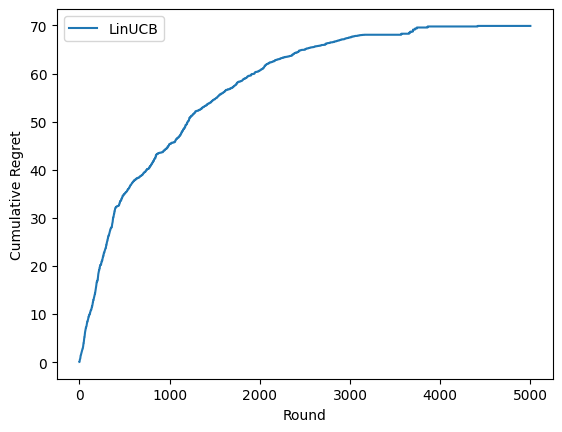

In [5]:
import matplotlib.pyplot as plt

linucb_regret = np.cumsum(
    np.array(oracle.optimal_rewards) - np.array(oracle.expected_rewards)
)

plt.plot(linucb_regret, label="LinUCB")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

plt.legend()


`upper_confidence_bound` is not guaranteed to do well, and can often involve fine-tuning the `alpha` parameter. Instead, we may want to use the `thompson_sampling` policy, which does not require any tuning.

In [6]:
from bayesianbandits import ThompsonSampling

thompson_oracle = ClickthroughOracle()

thompson_agent = ContextualAgent(
    arms=[
        Arm(Article.article_1, learner=NormalInverseGammaRegressor()),
        Arm(Article.article_2, learner=NormalInverseGammaRegressor()),
        Arm(Article.article_3, learner=NormalInverseGammaRegressor()),
        Arm(Article.article_4, learner=NormalInverseGammaRegressor()),
    ],
    policy=ThompsonSampling(),
)



Much as we did with the UCB algorithm, we'll run the bandit for 5000 iterations, and plot the cumulative regret over time.

In [7]:
np.random.seed(111)

for _ in range(5000):

    user_gender = np.random.binomial(1, 0.5) # 0 corresponds to female
    user_age = np.random.randint(0, 47) # 0 corresponds to age 18

    context = np.array([1.0, user_age, user_gender])

    thompson_oracle.set_context(context)
    thompson_oracle.best_expected_reward()

    action, = thompson_agent.pull(context)
    action.take_action(thompson_oracle)
    thompson_agent.update(context, thompson_oracle.rewards[-1] - 0.5)


We can see that both the UCB and Thompson sampling algorithms achieve sublinear regret, though LinUCB does quite a bit better for this realization of the problem.

At the end of the day, the choice of algorithm depends on the problem at hand. Thompson sampling is known to do fairly well in practice for a wide variety of problems, but UCB is also a good choice. The relative performance of these two algorithms often depends on the choice of prior, as well, which is a topic for another notebook.

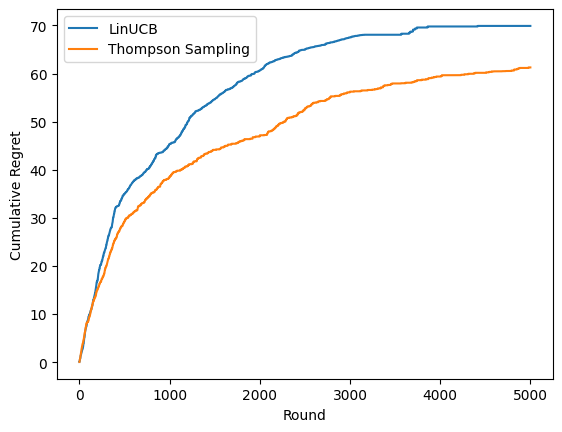

In [8]:
thompson_regret = np.cumsum(
    np.array(thompson_oracle.optimal_rewards) - np.array(thompson_oracle.expected_rewards)
)

plt.plot(linucb_regret, label="LinUCB")
plt.plot(thompson_regret, label="Thompson Sampling")

plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

plt.legend()
